In [1]:
wdir="AM_videogames/"
chosen_game='diablo III'
game_list= ['diablo III', 'God of War III', 'The Last of Us', 'Mario Kart',
       'StarCraft II: Wings of Liberty']## Keep 1000 most common features and extract features vectors

In [4]:
######################### imports external libraries ##########################
from joblib import dump, load
import pandas as pd
import numpy as np
import csv
from os import path
import time
import pickle
import os
import matplotlib.pyplot as plt
import operator 
from sklearn import cluster
from sklearn import metrics
import json
import sys
import codecs
from nltk.corpus import wordnet
from collections import defaultdict, Counter
import matplotlib as mpl
from gensim.models import KeyedVectors


# read csv FOPs

In [5]:

FOPs_df = pd.read_csv(wdir+chosen_game+"_FOPs.csv")  # Creation of the dataframe 
FOPs_df["polarity"] = FOPs_df["importance"]/FOPs_df["count"]
FOPs_df["importance"]= abs(FOPs_df["importance"])
FOPs_df = FOPs_df.sort_values('importance', ascending=False)
FOPs_df=FOPs_df.reset_index(drop=True)
print(FOPs_df.shape)
FOPs_df.head()


(23005, 5)


,feature,opinion,count,importance,polarity
0,items,lettered,44,25.3464,0.576055
1,items,better,22,16.2470,0.738500
2,auction,good,20,11.5646,0.578230
3,house,good,20,11.5646,0.578230
4,time,good,16,11.5630,0.722688


# Keep 1000 most common features and get WN tags

In [25]:
Common_features=FOPs_df.groupby(["feature"]).size().reset_index(name='counts').sort_values('counts', 
                                                        ascending=False).reset_index(drop=True)[:1000]
F_list=list(Common_features.feature.unique())
print(len(F_list), " features")
O_list=list(FOPs_df.opinion.unique())
print(len(O_list), " opinions")
lines=[feature + ".n.01" for feature in F_list]
lines

1000  features
1999  opinions


['time.n.01',
 'fun.n.01',
 'character.n.01',
 'auction.n.01',
 'player.n.01',
 'house.n.01',
 'people.n.01',
 'items.n.01',
 'level.n.01',
 'money.n.01',
 'hours.n.01',
 'item.n.01',
 'system.n.01',
 'characters.n.01',
 'gold.n.01',
 'skills.n.01',
 'difficulty.n.01',
 'gameplay.n.01',
 'lot.n.01',
 'internet.n.01',
 'servers.n.01',
 'story.n.01',
 'expansion.n.01',
 'class.n.01',
 'monsters.n.01',
 'players.n.01',
 'levels.n.01',
 'skill.n.01',
 'connection.n.01',
 'loot.n.01',
 'friends.n.01',
 'inferno.n.01',
 'graphics.n.01',
 'world.n.01',
 'gear.n.01',
 'computer.n.01',
 'experience.n.01',
 'act.n.01',
 'server.n.01',
 'day.n.01',
 'content.n.01',
 'patch.n.01',
 'armor.n.01',
 'weapons.n.01',
 'product.n.01',
 'mode.n.01',
 'classes.n.01',
 'review.n.01',
 'company.n.01',
 'reviews.n.01',
 'times.n.01',
 'hell.n.01',
 'stats.n.01',
 'battle.n.01',
 'progress.n.01',
 'enemies.n.01',
 'days.n.01',
 'ii.n.01',
 'fan.n.01',
 'release.n.01',
 'problem.n.01',
 'witch.n.01',
 'customi

685
685
 * clustering...
 * saved results to: AM_videogames/WN_k20.json


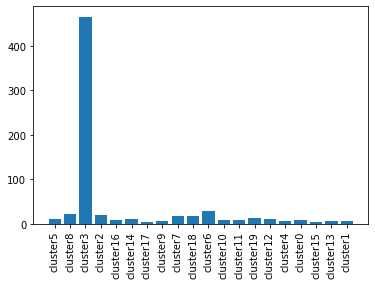

In [45]:

k = 20 #"cluster number"
sim_threshold = 0.9 # "similarity threshold for WN"

data = [_mk_synset(w) for w in lines if _mk_synset(w)]
print(len(data))
data, labels = make_data_matrix(data, sim_threshold)

print(len(data))
print( ' *', 'clustering...')
word_cluster(data, labels, k=k, show_histogram_plot=True)


In [40]:
print(len(labels))

685


In [23]:

mpl.rcParams['toolbar'] = 'None'

wvmodel = None

# make False to switch to wordvectors
use_wordnet = True

modelFile = wdir+ "glove.6B.300d_word2vec.txt"

cache = {}



In [42]:

def _mk_synset(w):
    #
    # turn cat.n.01 into the Synset object form
    #
    
    word = w.strip()
    if '.' in word:
#         print(word)
        try:
            return wordnet.synset(word)
        except:
            return None
    else:
        print(' * Error, invalid synset name', w, 'skipping...')
        return None

def _mk_wv_word(s):
    #
    # turn wordnet Synset into word2vec word form
    #   e.g. cat.n.01 -> 'cat'
    #   e.g. free_trade.n.01 -> free-trade
    return s.lemmas()[0].name().replace('_', '-')



def load_tags(filename):
    with codecs.open(filename, 'rb', 'utf-8') as tagfile:
        lines = [line for line in tagfile.readlines() if not line.startswith('#')]
        data = [_mk_synset(w) for w in lines if _mk_synset(w)]
        print(' *', 'loaded', len(data), 'wordnet senses,', len(lines) - len(data), 'rejected')
        return data

#
# wordvectors similarity distance
#

def wv(w1, w2, t):
    # lazy load the wordvector model...
    global wvmodel
    if wvmodel == None:
        print(' *', 'loading wordvector model (', modelFile, ')...') 
        wvmodel = KeyedVectors.load_word2vec_format(modelFile, binary=False)
        wvmodel.init_sims(replace=True)  # no more updates, prune memory

    try:
        #
        # since we've got wordnet synset objects (like cat.n.01), we
        # must turn this back into a regular word ('cat') because the
        # word vector GloVe models are plain words with spaces turned
        # into hyphens on phrases (e.g. climate-change, black-and-white)
        #
        wv_w1, wv_w2 = _mk_wv_word(w1), _mk_wv_word(w2)
        distance = wvmodel.similarity(wv_w1, wv_w2)
        return distance if abs(distance) >= t else 0
    except:
        return 0

#
# wordnet wup similarity distance
#


def wup(w1, w2, t):
    distance = w1.wup_similarity(w2)
    if distance:
        if distance >= t:
            return distance
    return 0

#
# wordnet path similarity distancewv
#


def path(w1, w2, t):
    distance = w1.path_similarity(w2)
    if distance:
        if distance >= t:
            return distance
    return 0

#
# Normalized distance between any two words as represented
# by wordnet synsets
#


def word_to_word_distance(w1, w2, t):
    if w1 == w2:
        return 1.0
    else:
        global cache
        s = sorted([w1, w2])
        x = (s[0], s[1])
        if x in cache:
            return cache[x]
        else:
            distances = []
            if use_wordnet:
                distances.append(wup(x[0], x[1], t))
                distances.append(path(x[0], x[1], t))
            else:
                # scale threshold between wm and wv
                distances.append(wv(w1, w2, t / 2.5))
            d = sum(distances) / len(distances)
            cache[x] = d
            return d


def make_data_matrix(words, t):
    list_of_vectors = []
    for word_x in words:
        wordvector = []
        for word_y in words:
            wordvector.append(word_to_word_distance(word_x, word_y, t))
        list_of_vectors.append(wordvector)

    data = np.array(np.array(list_of_vectors))
    labels = words
    return (data, labels)


def show_histogram(d):
    c = {k: len(d[k]) for k in d.keys()}
    bars, heights = zip(*c.items())
    y_pos = range(len(bars))
    plt.bar(y_pos, heights)
    plt.xticks(y_pos, bars, rotation=90)
    plt.show()


def word_cluster(data, labels, k, show_histogram_plot=True):
    k_means = cluster.KMeans(n_clusters=k)
    k_means.fit(data)

    # for i, label in enumerate(labels):
    #    print ' *', label, k_means.labels_[i]

    d = defaultdict(list)
    for c, l in zip(k_means.labels_, labels):
        d['cluster' + str(c)].append(l.name())

    fname = wdir
    fname += "WN"
    fname += '_k' + str(k) + '.json'

    with codecs.open(fname, 'wb', 'utf-8') as outfile:
        outfile.write(json.dumps(d, indent=True))
        print( ' * saved results to:', fname)
        # create histogram of cluster sizes
        if show_histogram_plot:
            show_histogram(d)



            
